In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.distributions as dists
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from models import AE_MNIST
import utils as ut

In [2]:
# transforms
lst_trans = []

deg = 45
distortion_scale = 0.5
p = 0.5

lst_trans.append(
    transforms.Compose([
        torchvision.transforms.RandomRotation(degrees=(-deg, deg)),
        torchvision.transforms.RandomPerspective(distortion_scale, p),
        transforms.ToTensor(),
    ]))

lst_trans.append(
    transforms.Compose([
        torchvision.transforms.RandomRotation(degrees=(-deg, deg)),
        torchvision.transforms.RandomPerspective(distortion_scale, p),
        transforms.ToTensor(),
    ]))

transform = ut.Transform(lst_trans)

# dataset
dataset_train = MNIST(root='./data', train=True, transform=transform)
dataset_test = MNIST(root='./data', train=False, transform=transform)

# loader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# device
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# model
model = AE_MNIST(2).to(device)

# optim
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-3, 
                             weight_decay=5e-4)

# estimation
loss = ut.SimCLR()

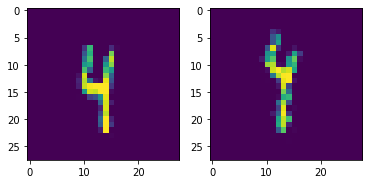

In [3]:
# plot loader
fig, ax = plt.subplots(1, 2)
for i, (lst_x, _) in enumerate(loader_test):
    x = lst_x[0]
    ax[0].imshow(x[0, 0])
    x = lst_x[1]
    ax[1].imshow(x[0, 0])
    break

In [ ]:
log = {
    'loss_train': [],
    'loss_test': [],
}

for epoch in range(200):
    # train
    lst_l = []
    for lst_x, _ in loader_train:
        lst_z = []
        for x in lst_x:
            x = x.to(device)
            lst_z.append(model.encode(x))
        l = loss(lst_z)
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()
        lst_l.append(l.item())
    log['loss_train'].append(np.mean(lst_l))
    # test
    lst_l = []
    with torch.no_grad():
        for lst_x, _ in loader_test:
            lst_z = []
            for x in lst_x:
                x = x.to(device)
                lst_z.append(model.encode(x))
            l = loss(lst_z)
        lst_l.append(l.item())
    log['loss_test'].append(np.mean(lst_l))
    # log
    print(
        f"epoch: {epoch+1}",
        f"train: {log['loss_train'][-1]: .5f}",
        f"test: {log['loss_test'][-1]: .5f}",
    )

epoch: 1 train:  3.18385 test:  2.23535
epoch: 2 train:  2.68681 test:  2.16679
epoch: 3 train:  2.59802 test:  1.66996
epoch: 4 train:  2.52487 test:  1.67667
epoch: 5 train:  2.48301 test:  1.72675
epoch: 6 train:  2.44271 test:  2.12911
epoch: 7 train:  2.42777 test:  1.55919
epoch: 8 train:  2.39856 test:  1.76986
epoch: 9 train:  2.38344 test:  1.66605
epoch: 10 train:  2.37339 test:  1.73366
epoch: 11 train:  2.36205 test:  1.68533
epoch: 12 train:  2.35379 test:  2.27514
epoch: 13 train:  2.34507 test:  1.99616
epoch: 14 train:  2.32500 test:  2.16329
epoch: 15 train:  2.32124 test:  1.77169
epoch: 16 train:  2.31294 test:  1.59388
epoch: 17 train:  2.30419 test:  1.67923
epoch: 18 train:  2.30237 test:  1.69470
epoch: 19 train:  2.29251 test:  1.47889
epoch: 20 train:  2.29383 test:  2.00643
epoch: 21 train:  2.27285 test:  1.28473
epoch: 22 train:  2.27706 test:  2.03859
epoch: 23 train:  2.27219 test:  1.25653


In [ ]:
# plot encoder

# dataset
transform = transforms.ToTensor()
dataset = MNIST(root='./data', train=False, transform=transform)

# loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

plt.figure(figsize=(10, 10))
for x, y in loader:
    x = x.to(device)
    z = model.encode(x)
    z = z.cpu().detach()
    #z = z/z.norm(1)
    y = y.cpu()
    for label in range(10):
        idx = y == label
        plt.scatter(z[idx,0], z[idx,1])
    plt.legend(np.arange(10, dtype=np.int32))
plt.show()